## Installation

### LangSmith

In [1]:
import getpass
import os

os.environ["LANGSMITH_TRACING"] = os.getenv("LANGSMITH_TRACING")
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI()
llm.invoke("Hello, world!")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 11, 'total_tokens': 20, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BbMvIN40EXFFN8idH3sY0eFI9dNEM', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--b772bc27-d57f-493c-bb6e-4788a065a299-0', usage_metadata={'input_tokens': 11, 'output_tokens': 9, 'total_tokens': 20, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

### Components

#### Chat model

In [3]:
import getpass
import os

from langchain.chat_models import init_chat_model

llm = init_chat_model("gpt-4o-mini", model_provider="openai")

#### Embeding

In [4]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

#### Vector Store

In [5]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

## Processing

### 1. Indexing

#### Loading documents

In [6]:
from langchain_community.document_loaders.csv_loader import CSVLoader

loader = CSVLoader(
    #Integration specific parameters here
    file_path="../data/answers_table.csv",
    csv_args={
        "delimiter": ",",
        "quotechar": '"',
        "fieldnames": ["Sender_Name", "Sender_ID", "Date", "Text", "Reply_To_Message_ID", "Question"],
    },
)
# data = loader.load()
docs = loader.load()

In [7]:
print(docs[1].page_content)

Sender_Name: David Mulish | I'll never DM first
Sender_ID: user1835306285
Date: 2025-01-06 00:25:22
Text: Hello! If you want to withdraw EVER from your EVER Wallet directly, you can deposit it on KuCoin/MEXC/Gate.io
Reply_To_Message_ID: 24907
Question: How can I withdraw my Ever


#### Splitting documents

In [8]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=100,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 453 sub-documents.


In [9]:
print("\n--- Проверка Document после Text Splitter ---")
# Пройдитесь по всем кускам, связанным с исходным problematic_doc
for chunk_doc in all_splits:
    if chunk_doc.metadata.get('row') == 5: # Опять же, используйте нужный row
        print(f"ID: {chunk_doc.id}")
        print(f"Metadata: {chunk_doc.metadata}")
        print(f"Page Content:\n{chunk_doc.page_content}")
        print("-" * 30)



--- Проверка Document после Text Splitter ---
ID: None
Metadata: {'source': '../data/answers_table.csv', 'row': 5, 'start_index': 0}
Page Content:
Sender_Name: David Mulish | I'll never DM first
Sender_ID: user1835306285
Date: 2025-01-06 20:14:01
Text: There are two ways: 1) you can withdraw EVER (ERC-20) to your Metamask, then use Octus Bridge to transfer EVER to Everscale network (to your EVER Wallet). But you will pay a heavy gas fee for it.  2) the simplest and cheapest way is: change your EVER to USDT, withdraw USDT to KuCoin/MEXC/Gate.io and buy EVER there. You can withdraw EVER from KuCoin/MEXC/Gate.io to EVER Wallet directly
Reply_To_Message_ID: 24922
Question: Good day🙏 Tell me please how can I get Ever to Ever wallet? I got Ever on Bybit
------------------------------


#### Storing documents

In [10]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['d87f1b36-68da-42f1-99b0-236e6c504df7', '91910c1f-2df1-4677-a641-721b1fe174a4', 'd319350e-0fdb-4b87-87fc-8a18ed376557']


### 2. Retrieval and Generation

In [11]:
from langchain_core.prompts import PromptTemplate

template = """
Act as a highly skilled and empathetic Technical Support Specialist for a Telegram channel. 
Your core responsibility is to analyze the user's question and the provided historical support context 
to formulate an answer that not only matches the style, tone, and manner of the existing support team but
also delivers a solution analogous to how previous specialists have addressed similar issues. 

Crucially, observe if the historical answers sometimes advise users to contact an administrator directly instead of providing a full public solution. 
If such a pattern is present for similar questions, or if the question seems to require private assistance, 
instruct the user to contact one of the following administrators: 
David Mulish | I'll never DM first, John Coltrane (I'll Never DM First), Andrew, or Aleksandr | Everscale. 
In this case, do not attempt to answer the question directly. 
Otherwise, 
Focus on extracting the most relevant information from the Context to construct your response. 
If the Context does not provide a direct or inferable solution, clearly state that you don't know the answer, avoiding any fabrication.
All questions must be in English language, otherwise ask user to rephrase the question in English like "This chat is for English language communication."
If you dont know the answer, kindly ask user to rephrase the question.

Your answers should be concise, professional, and helpful.

Here is the Context:
###
{context}
###

User's question: 
###
{question}
###

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

#### Create the Graph

In [12]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict

class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = custom_rag_prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

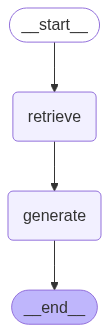

In [13]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## RAG TEST

In [14]:
result = graph.invoke({"question": "How can I withdraw my Ever?"})
# result = graph.invoke({"question": "Как заказать пиццу?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='91910c1f-2df1-4677-a641-721b1fe174a4', metadata={'source': '../data/answers_table.csv', 'row': 1, 'start_index': 0}, page_content="Sender_Name: David Mulish | I'll never DM first\nSender_ID: user1835306285\nDate: 2025-01-06 00:25:22\nText: Hello! If you want to withdraw EVER from your EVER Wallet directly, you can deposit it on KuCoin/MEXC/Gate.io\nReply_To_Message_ID: 24907\nQuestion: How can I withdraw my Ever"), Document(id='d1bedf2f-6ec2-48e3-9a0c-357892d193db', metadata={'source': '../data/answers_table.csv', 'row': 8, 'start_index': 0}, page_content="Sender_Name: John Coltrane (I'll Never DM First)\nSender_ID: user5204190482\nDate: 2025-01-07 00:52:15\nText: Hello! If you want to withdraw EVER directly from your EVER wallet, you can withdraw them to KuCoin/MEXC/Gate.io. If to other networks, then via app.OctusBridge.io\nReply_To_Message_ID: 24937\nQuestion: Hello how can I withdraw my ever coin?"), Document(id='37755fe0-537a-49aa-81b9-3b3c6c64873f', metadat

In [15]:
result["context"]

[Document(id='91910c1f-2df1-4677-a641-721b1fe174a4', metadata={'source': '../data/answers_table.csv', 'row': 1, 'start_index': 0}, page_content="Sender_Name: David Mulish | I'll never DM first\nSender_ID: user1835306285\nDate: 2025-01-06 00:25:22\nText: Hello! If you want to withdraw EVER from your EVER Wallet directly, you can deposit it on KuCoin/MEXC/Gate.io\nReply_To_Message_ID: 24907\nQuestion: How can I withdraw my Ever"),
 Document(id='d1bedf2f-6ec2-48e3-9a0c-357892d193db', metadata={'source': '../data/answers_table.csv', 'row': 8, 'start_index': 0}, page_content="Sender_Name: John Coltrane (I'll Never DM First)\nSender_ID: user5204190482\nDate: 2025-01-07 00:52:15\nText: Hello! If you want to withdraw EVER directly from your EVER wallet, you can withdraw them to KuCoin/MEXC/Gate.io. If to other networks, then via app.OctusBridge.io\nReply_To_Message_ID: 24937\nQuestion: Hello how can I withdraw my ever coin?"),
 Document(id='37755fe0-537a-49aa-81b9-3b3c6c64873f', metadata={'sou

In [16]:
def print_context(result):
    print(f'Answer:\n{result["answer"]}\n')
    print('Context:')
    for doc in result["context"]:
        content = doc.page_content 
        
        question = ""
        answer_text = ""
        
        for line in content.split('\n'):
            if line.startswith('Question:'):
                question = line.replace('Question:', '').strip()
            # Предполагаем, что ответ всегда в поле 'Text:'
            elif line.startswith('Text:'):
                answer_text = line.replace('Text:', '').strip()
        
        print(f'q: {question}')
        print(f'a: {answer_text}\n')

print_context(result)

Answer:
Hello! To withdraw your EVER directly from your EVER Wallet, you can deposit it on exchanges like KuCoin, MEXC, or Gate.io. If you need further assistance, please consider reaching out to one of the administrators: David Mulish | I'll never DM first, John Coltrane (I'll Never DM First), Andrew, or Aleksandr | Everscale.

Context:
q: How can I withdraw my Ever
a: Hello! If you want to withdraw EVER from your EVER Wallet directly, you can deposit it on KuCoin/MEXC/Gate.io

q: Hello how can I withdraw my ever coin?
a: Hello! If you want to withdraw EVER directly from your EVER wallet, you can withdraw them to KuCoin/MEXC/Gate.io. If to other networks, then via app.OctusBridge.io

q: Good day🙏 Tell me please how can I get Ever to Ever wallet? I got Ever on Bybit
a: There are two ways: 1) you can withdraw EVER (ERC-20) to your Metamask, then use Octus Bridge to transfer EVER to Everscale network (to your EVER Wallet). But you will pay a heavy gas fee for it.  2) the simplest and che

In [17]:
result = graph.invoke({"question": "How can I get the rewards in hamster"})
print_context(result)

Answer:
To get rewards in Hamster Boost, you can check for a message on the green background at the top of the mini app, which informs you about any rewards you've received. If you need further assistance or specific instructions, please refer to this link: [Hamster Boost Rewards Instructions](https://t.me/broxus_chat/26814). If you have more questions or need help beyond this, please feel free to contact one of the administrators: David Mulish, John Coltrane, Andrew, or Aleksandr.

Context:
q: How to get a reward?
a: If you have received a reward in Hamster Boost, there is a message about it on the green background at the top of the mini app.

q: I get the reward in hamster deve but how it received in my sparx wallet
a: https://t.me/broxus_chat/26814

q: I need  how  to get my reward
a: Hi. If you have received a reward in Hamster Boost, there is a message about it on the green background at the top of the mini app.

q: Please help how to get
a: Hey! If you have received a reward in H

In [18]:
result = graph.invoke({"question": "Как заказать пиццу?"})
print_context(result)

Answer:
This chat is for English language communication. Please rephrase your question in English so I can assist you further. Thank you!

Context:
q: Не получается?
a: This chat is for English language communication. Send me a DM with the details of your problem.

q: Где тут по русски???????
a: Here: https://t.me/OctusBridge_ru

q: How possible
a: Hello! Please describe in detail what do you wish?

q: Здравствуйте
a: Hello. This chat is for English-language communication only. Write me in DM with your wallet address and details of the problem. Be careful, admins never write first.



In [19]:
result = graph.invoke({"question": "Please i used octusbridge but my assets were not transferred, i saw burn at the ever scan?"})
print_context(result)

Answer:
It seems your transaction might not have gone through as expected. In this case, it's advisable to reach out directly to one of the administrators for assistance. You can contact David Mulish, John Coltrane, Andrew, or Aleksandr for further support regarding your assets and the transaction status.

Context:
q: What did you mean ?  I was trying to buy ever by using EVM wallet.  Can you please explain about what you have just said?
a: You can transfer USDT/USDC/wETH/wBTC via app.octusbridge.io to Everscale . Then buy on https://app.flatqube.io/tokens/0:a49cd4e158a9a15555e624759e2e4e766d22600b7800d891e46f9291f044a93d

q: While trying to unstake BRIDGE tokens from an Octus Bridge relay. Is it safe to proceed?
a: You should copy an address from the warning message.  1. Top up the address with 0.2 ever and try again.  2. If there is the warning again, you need to unfreeze the address via https://ever.bytie.moe/microwave

q: Hello  I buy ever about 12000 usdt in my atomic wallet
a: Hi

In [20]:
result = graph.invoke({"question": "But in the Mexc exchange now when I want to withdraw ever, I saw the freeton everscale,it is the everscale,it is just that they do not change the name? to just everscale?"})
print_context(result)

Answer:
Hello! Yes, Everscale was previously known as FreeTON and has undergone rebranding. The exchange may still display the old name, but it's essentially the same blockchain project. If you have any further inquiries regarding your specific withdrawals or account issues, please reach out to one of the administrators: David Mulish, John Coltrane, Andrew, or Aleksandr. They'll be able to assist you more directly.

Context:
q: EverScale is Freeton?
a: That's right. Everscale used to be called FreeTON. It was rebranded in 2021: https://www.prnewswire.com/news-releases/free-ton-announces-ecosystem-rebrand-to-everscale-strengthening-its-scalability-mission-301421459.html

q: Hello how can I withdraw my ever coin?
a: Hello! If you want to withdraw EVER directly from your EVER wallet, you can withdraw them to KuCoin/MEXC/Gate.io. If to other networks, then via app.OctusBridge.io

q: Good day🙏 Tell me please how can I get Ever to Ever wallet? I got Ever on Bybit
a: There are two ways: 1) yo

In [21]:
result = graph.invoke({"question": "Как я могу вывести свои Ever с биржи Bybit?"})
print_context(result)

Answer:
This chat is for English language communication. Please rephrase your question in English.

Context:
q: Good day🙏 Tell me please how can I get Ever to Ever wallet? I got Ever on Bybit
a: There are two ways: 1) you can withdraw EVER (ERC-20) to your Metamask, then use Octus Bridge to transfer EVER to Everscale network (to your EVER Wallet). But you will pay a heavy gas fee for it.  2) the simplest and cheapest way is: change your EVER to USDT, withdraw USDT to KuCoin/MEXC/Gate.io and buy EVER there. You can withdraw EVER from KuCoin/MEXC/Gate.io to EVER Wallet directly

q: How can I withdraw my Ever
a: Hello! If you want to withdraw EVER from your EVER Wallet directly, you can deposit it on KuCoin/MEXC/Gate.io

q: Hello how can I withdraw my ever coin?
a: Hello! If you want to withdraw EVER directly from your EVER wallet, you can withdraw them to KuCoin/MEXC/Gate.io. If to other networks, then via app.OctusBridge.io

q: Good day🙏 Tell me please how can I get Ever to Ever wallet?